In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import konlpy
from konlpy.tag import Okt
from keras.layers import Embedding, Dense, LSTM, Activation
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

Using TensorFlow backend.


In [7]:
df = pd.read_excel("외교부_알람_input_v0.0.3_요약.xlsx")

In [8]:
df.head()

,wrtDt,id,countryName,title,content,Div,Label
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0


In [9]:
len(df)

4903

In [10]:
df = df.loc[pd.notnull(df['Label'])]
print(len(df))

4903


In [11]:
df['Content'] = df.apply(lambda x: np.nan if pd.isnull(x['title']) and pd.isnull(x['content']) else x['title'] if pd.isnull(x['content']) else x['title'] + ' ' + x['content'] , axis=1)

In [7]:
# df = df[['Content']]

In [12]:
df.head()

,wrtDt,id,countryName,title,content,Div,Label,Content
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내 &nbs...
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1,홍콩 시위 관련 안전공지(5.26) 홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안...
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1,호주 열대성 폭풍 Manga 관련 안전 공지 ㅇ 열대성 폭풍 Manga가 5.24....
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0,태국 뎅기열 유행에 따른 유의사항 태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태...
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 ‘우리 기업인 대상’ 헝가리 입국...


In [13]:
from konlpy.tag import Okt

stopwords = ['콜센터', '등', '및', '번호', '전', '하다', '하여', '월', '화', '수', '목', '금', '토', '일']

X = []
okt = Okt()

for i in range(len(df)):
    _x = df.iloc[i]['Content']
    
    okt_morphs = okt.pos(_x)  # 튜플반환
    temp_x = []
    for word, pos in okt_morphs:
        if pos == 'Noun' or pos == 'Verb':
            temp_x.append(word)
            
    temp_x = [word for word in temp_x if not word in stopwords]
    X.append(temp_x)
    

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

제목의 최대 길이 :  1728
제목의 평균 길이 :  134.84356516418518


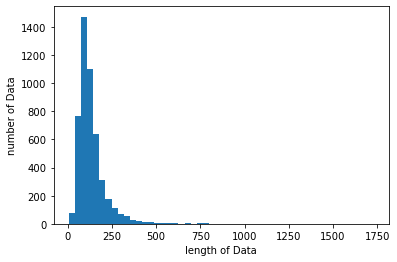

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

print("제목의 최대 길이 : ", max(len(l) for l in X))
print("제목의 평균 길이 : ", sum(map(len, X))/ len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [15]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

max_len = max(len(l) for l in X) # 전체 데이터의 길이를 20로 맞춘다
# max_len = 1728
X = pad_sequences(X, maxlen=max_len)

In [16]:
X

array([[   0,    0,    0, ...,  146,  466,   26],
       [   0,    0,    0, ..., 1705,   48,  287],
       [   0,    0,    0, ...,   31,   19,    4],
       ...,
       [   0,    0,    0, ...,   19,    4, 2630],
       [   0,    0,    0, ...,  425,   35,    4],
       [   0,    0,    0, ...,    7,    2, 2630]])

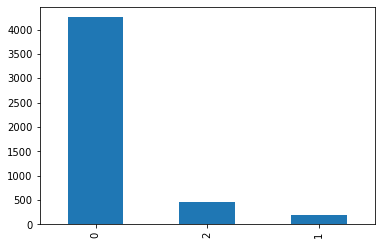

In [17]:
df['Label'].value_counts().plot(kind='bar')

In [18]:
df['Label'].value_counts()

0    4250
2     458
1     195
Name: Label, dtype: int64

In [19]:
Y = to_categorical(df['Label'])

In [20]:
Y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [24]:
# 다층 LSTM을 구현하기 위한 함수
def stacked_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 100))
    model.add(LSTM(50, return_sequences = True))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

# model = KerasClassifier(build_fn = stacked_lstm, epochs = 200, batch_size = 50, verbose = 1)
model = KerasClassifier(build_fn = stacked_lstm, epochs = 10, batch_size = 10, verbose = 1, validation_split=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_test_ = np.argmax(y_test, axis = 1)
print(accuracy_score(y_pred, y_test_))

Train on 3529 samples, validate on 393 samples
Epoch 1/10
3529/3529 [==============================] - 495s 140ms/step - loss: 0.4491 - accuracy: 0.8674 - val_loss: 0.3825 - val_accuracy: 0.8957
Epoch 2/10
3529/3529 [==============================] - 492s 140ms/step - loss: 0.2952 - accuracy: 0.8960 - val_loss: 0.3923 - val_accuracy: 0.8906
Epoch 3/10
3529/3529 [==============================] - 507s 144ms/step - loss: 0.3078 - accuracy: 0.8932 - val_loss: 0.5216 - val_accuracy: 0.8830
Epoch 4/10
3529/3529 [==============================] - 493s 140ms/step - loss: 0.3215 - accuracy: 0.8767 - val_loss: 0.3897 - val_accuracy: 0.8830
Epoch 5/10
3529/3529 [==============================] - 495s 140ms/step - loss: 0.2971 - accuracy: 0.8892 - val_loss: 0.4056 - val_accuracy: 0.8753
Epoch 6/10
3529/3529 [==============================] - 499s 141ms/step - loss: 0.2084 - accuracy: 0.9260 - val_loss: 0.4012 - val_accuracy: 0.8626
Epoch 7/10
3529/3529 [==============================] - 493s 140m

In [25]:
y_output = model.predict(X)

4903/4903 [==============================] - 105s 21ms/step


In [26]:
y_output

array([0, 0, 1, ..., 0, 1, 0])

In [56]:
len(df)

4903

In [27]:
df.head()

,wrtDt,id,countryName,title,content,Div,Label,Content
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내 &nbs...
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1,홍콩 시위 관련 안전공지(5.26) 홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안...
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1,호주 열대성 폭풍 Manga 관련 안전 공지 ㅇ 열대성 폭풍 Manga가 5.24....
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0,태국 뎅기열 유행에 따른 유의사항 태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태...
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 ‘우리 기업인 대상’ 헝가리 입국...


In [28]:
df['New_Label'] = y_output

In [37]:
df = df.drop(columns=['Content'])

In [31]:
df['Check'] = df['Label'] == df['New_Label']

In [32]:
df.head()

,wrtDt,id,countryName,title,content,Div,Label,Content,New_Label,Check
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내 &nbs...,0,True
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1,홍콩 시위 관련 안전공지(5.26) 홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안...,0,False
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1,호주 열대성 폭풍 Manga 관련 안전 공지 ㅇ 열대성 폭풍 Manga가 5.24....,1,True
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0,태국 뎅기열 유행에 따른 유의사항 태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태...,0,True
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 ‘우리 기업인 대상’ 헝가리 입국...,0,True


In [38]:
df.to_excel("output.xlsx", index=False, engine='xlsxwriter')

In [36]:
df['New_Label'].value_counts()

0    4250
2     439
1     214
Name: New_Label, dtype: int64

In [40]:
df['Label'].value_counts()

0    4250
2     458
1     195
Name: Label, dtype: int64

In [41]:
df.loc[df['New_Label']==2]['Check'].value_counts()

True     361
False     78
Name: Check, dtype: int64

In [52]:
df.loc[df['Label']==2]['New_Label'].value_counts()

2    361
0     71
1     26
Name: New_Label, dtype: int64

In [53]:
df.loc[df['New_Label']==2]['Label'].value_counts()

2    361
0     46
1     32
Name: Label, dtype: int64

In [44]:
len(df.loc[df['Label']==df['New_Label']])/len(df)*100

94.12604527840098

In [55]:
len(df.loc[df['Label']==0])/len(df)*100

86.68162349581888

In [42]:
# 다층 LSTM을 구현하기 위한 함수
def stacked_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 100))
    model.add(LSTM(50, return_sequences = True))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

# model = KerasClassifier(build_fn = stacked_lstm, epochs = 200, batch_size = 50, verbose = 1)
model2 = KerasClassifier(build_fn = stacked_lstm, epochs = 10, batch_size = 50, verbose = 1, validation_split=0.2)
model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)
y_test_ = np.argmax(y_test, axis = 1)
print(accuracy_score(y_pred, y_test_))

C:\Users\min-sung.lee\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3137 samples, validate on 785 samples
Epoch 1/10
3137/3137 [==============================] - 134s 43ms/step - loss: 0.5672 - accuracy: 0.8655 - val_loss: 0.4713 - val_accuracy: 0.8662
Epoch 2/10
3137/3137 [==============================] - 141s 45ms/step - loss: 0.3945 - accuracy: 0.8731 - val_loss: 0.4342 - val_accuracy: 0.8752
Epoch 3/10
3137/3137 [==============================] - 162s 52ms/step - loss: 0.2557 - accuracy: 0.9060 - val_loss: 0.4630 - val_accuracy: 0.8739
Epoch 4/10
3137/3137 [==============================] - 146s 46ms/step - loss: 0.1727 - accuracy: 0.9318 - val_loss: 0.5788 - val_accuracy: 0.8650
Epoch 5/10
3137/3137 [==============================] - 144s 46ms/step - loss: 0.1320 - accuracy: 0.9493 - val_loss: 0.5514 - val_accuracy: 0.8561
Epoch 6/10
3137/3137 [==============================] - 147s 47ms/step - loss: 0.1171 - accuracy: 0.9512 - val_loss: 0.6163 - val_accuracy: 0.8522
Epoch 7/10
3137/3137 [==============================] - 155s 50ms/step 

In [43]:
y_output = model2.predict(X)

4903/4903 [==============================] - 70s 14ms/step


In [45]:
df['New_Label2'] = y_output

In [46]:
df['New_Label2'].value_counts()

0    4281
2     454
1     168
Name: New_Label2, dtype: int64

In [47]:
df['Check2'] = df['Label'] == df['New_Label2']

In [48]:
df.loc[df['New_Label2']==2]['Check2'].value_counts()

True     351
False    103
Name: Check2, dtype: int64

In [49]:
len(df.loc[df['Label']==df['New_Label2']])/len(df)*100

94.10564960228432

In [50]:
df.loc[df['New_Label2']==2]['Label'].value_counts()

2    351
0     82
1     21
Name: Label, dtype: int64

In [51]:
df.loc[df['Label']==2]['New_Label2'].value_counts()

2    351
0     96
1     11
Name: New_Label2, dtype: int64

In [54]:
df.to_excel("output2.xlsx", index=False, engine='xlsxwriter')

In [57]:
# saving model
json_model = model.model.to_json()
open('model_architecture.json', 'w').write(json_model)
# saving weights
model.model.save_weights('model_weights.h5', overwrite=True)

In [60]:
model.model.save('model')

In [61]:
model.model.save('model2')

In [ ]:
# https://www.tensorflow.org/guide/keras/save_and_serialize

In [67]:
from tensorflow import keras
model = keras.models.load_model('model')

In [68]:
y_output = model.predict(X)

In [74]:
y_output

array([[9.7805917e-01, 1.5291702e-02, 6.6490890e-03],
       [9.9926251e-01, 4.4769785e-04, 2.8988029e-04],
       [2.4220429e-01, 7.0450735e-01, 5.3288355e-02],
       ...,
       [9.9950802e-01, 2.9016371e-04, 2.0180874e-04],
       [2.3570819e-02, 9.4342440e-01, 3.3004791e-02],
       [9.9948347e-01, 3.0709896e-04, 2.0951158e-04]], dtype=float32)

In [75]:
y_output_ = np.argmax(y_output, axis = 1)

In [76]:
y_output_

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [79]:
print(accuracy_score(df['Label'], y_output_))

0.9412604527840098


In [82]:
df['New_Label1'] = y_output_

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [85]:
df = pd.read_excel('output.xlsx')

In [86]:
df['New_Label1'] = y_output_

In [87]:
df

,wrtDt,id,countryName,title,content,Div,Label,New_Label,Check,New_Label1
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0,0,True,0
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1,0,False,0
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1,1,True,1
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0,0,True,0
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0,0,True,0
...,...,...,...,...,...,...,...,...,...,...
4898,2011-07-05,10822,아프가니스탄,"리비아, 이라크, 소말리아, 아프간 여행금지국 지정 연장",리비아․이라크․소말리아․아프간 여행금지국 지정 연장 1. 외교통상부는 7.4(월)...,NaN,2,2,True,2
4899,2011-07-05,10820,이라크,"리비아, 이라크, 소말리아, 아프간 여행금지국 지정 연장",리비아․이라크․소말리아․아프간 여행금지국 지정 연장 1. 외교통상부는 7.4(월)...,NaN,2,2,True,2
4900,2011-05-18,10811,체코,[체코] 여행시 안전유의사항 안내,[체코] 여행시 안전유의사항 안내 (가짜 사복경찰 주의 안내)여행철 관광객을 ...,NaN,0,0,True,0
4901,2011-02-16,10721,예멘,[예멘]중동지역 시위발생에 따른 신변안전유의 안내,"중동지역 사위발생에 따른 신변안전유의 안내 o 최근 알제리를 비롯하여, 바레인,...",치안,0,1,False,1


In [89]:
df.loc[df['New_Label']==df['New_Label1']]

,wrtDt,id,countryName,title,content,Div,Label,New_Label,Check,New_Label1
0,2020-05-27,ATC0000000007885,미국,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",정보,0,0,True,0
1,2020-05-26,ATC0000000007884,홍콩(중국),홍콩 시위 관련 안전공지(5.26),홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,치안,1,0,False,0
2,2020-05-23,ATC0000000007881,호주,호주 열대성 폭풍 Manga 관련 안전 공지,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,자연재해,1,1,True,1
3,2020-05-19,ATC0000000007857,태국,태국 뎅기열 유행에 따른 유의사항,태국 뎅기열 유행에 따른 유의사항 안내○ 최근 태국 동북부 지역에서 뎅기열 환자가 ...,질병,0,0,True,0
4,2020-05-19,ATC0000000007855,헝가리,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,정보,0,0,True,0
...,...,...,...,...,...,...,...,...,...,...
4898,2011-07-05,10822,아프가니스탄,"리비아, 이라크, 소말리아, 아프간 여행금지국 지정 연장",리비아․이라크․소말리아․아프간 여행금지국 지정 연장 1. 외교통상부는 7.4(월)...,NaN,2,2,True,2
4899,2011-07-05,10820,이라크,"리비아, 이라크, 소말리아, 아프간 여행금지국 지정 연장",리비아․이라크․소말리아․아프간 여행금지국 지정 연장 1. 외교통상부는 7.4(월)...,NaN,2,2,True,2
4900,2011-05-18,10811,체코,[체코] 여행시 안전유의사항 안내,[체코] 여행시 안전유의사항 안내 (가짜 사복경찰 주의 안내)여행철 관광객을 ...,NaN,0,0,True,0
4901,2011-02-16,10721,예멘,[예멘]중동지역 시위발생에 따른 신변안전유의 안내,"중동지역 사위발생에 따른 신변안전유의 안내 o 최근 알제리를 비롯하여, 바레인,...",치안,0,1,False,1
